# Real Estate Price Prediction   
<h3>Achille Nguessie</h3>

In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
from utils import *

# 4. Non-linear algorithms: Gradient Boosting algorithms & Random Forest

In [2]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('../data/data_no_outliers.csv')
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

In [5]:
# Dataset division into training=0.6, validation=0.2 and testing=0.2
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [6]:
def objective(trial):
    """
    Hyperparameter optimization function for Optuna.

    Parameters
    ----------
    trial : optuna.trial.Trial
        The Optuna trial object.

    Returns
    -------
    float
        The mean squared error of the model on the validation set.
    """
    model_name = trial.suggest_categorical('model', ['RandomForest', 'XGBoost', 'CatBoost', 'LightGBM'])
    
    if model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 5, 30)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    elif model_name == 'CatBoost':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        depth = trial.suggest_int('depth', 3, 10)
        model = CatBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate, depth=depth, verbose=0, random_state=42)
    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 5, 30)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        num_leaves = trial.suggest_int('num_leaves', 31, 256)
        model = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, num_leaves=num_leaves, random_state=42)
    
    # Creation of a pipeline with the scaler and the model
    pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                               ('model', model)])
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_val)
    mse = pow(root_mean_squared_error(y_val, preds),2)
    return mse

In [7]:

study = optuna.create_study(direction='minimize', study_name='First Hyperparams tuning')
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2024-11-09 04:46:45,842] A new study created in memory with name: First Hyperparams tuning


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-09 04:47:07,527] Trial 0 finished with value: 0.31559584848581634 and parameters: {'model': 'RandomForest', 'n_estimators': 631, 'max_depth': 8}. Best is trial 0 with value: 0.31559584848581634.
[I 2024-11-09 04:47:10,296] Trial 1 finished with value: 0.1937978345332469 and parameters: {'model': 'CatBoost', 'n_estimators': 403, 'learning_rate': 0.11129799821365713, 'depth': 9}. Best is trial 1 with value: 0.1937978345332469.
[I 2024-11-09 04:47:10,715] Trial 2 finished with value: 0.20288053459316396 and parameters: {'model': 'XGBoost', 'n_estimators': 319, 'max_depth': 6, 'learning_rate': 0.10655173653857773}. Best is trial 1 with value: 0.1937978345332469.
[I 2024-11-09 04:47:11,018] Trial 3 finished with value: 0.27610356503749306 and parameters: {'model': 'CatBoost', 'n_estimators': 119, 'learning_rate': 0.06398977768333071, 'depth': 5}. Best is trial 1 with value: 0.1937978345332469.
[I 2024-11-09 04:47:12,175] Trial 4 finished with value: 0.2141125473435534 and paramet

In [ ]:
# Best hyperparameters
print('Best trial: ')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Parameters:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')




Best trial: 
Value: 0.18372776046445602
Parameters:
    model: CatBoost
    n_estimators: 939
    learning_rate: 0.1424624832655008
    depth: 7


In [9]:
# Retraining of the best model on the training set + validation
best_model_name = trial.params['model']

if best_model_name == 'RandomForest':
    best_model = RandomForestRegressor(n_estimators=trial.params['n_estimators'],
                                       max_depth=trial.params['max_depth'],
                                       random_state=42)
elif best_model_name == 'XGBoost':
    best_model = xgb.XGBRegressor(n_estimators=trial.params['n_estimators'],
                                  max_depth=trial.params['max_depth'],
                                  learning_rate=trial.params['learning_rate'],
                                  random_state=42)
elif best_model_name == 'CatBoost':
    best_model = CatBoostRegressor(n_estimators=trial.params['n_estimators'],
                                   learning_rate=trial.params['learning_rate'],
                                   depth=trial.params['depth'],
                                   verbose=0,
                                   random_state=42)
elif best_model_name == 'LightGBM':
    best_model = lgb.LGBMRegressor(n_estimators=trial.params['n_estimators'],
                                   max_depth=trial.params['max_depth'],
                                   learning_rate=trial.params['learning_rate'],
                                   num_leaves=trial.params['num_leaves'],
                                   random_state=42)
    

X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

best_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                ('model', best_model)])

best_pipeline.fit(X_combined, y_combined)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x000002192D11DB20>)])

In [10]:
import pickle
pickle.dump(best_pipeline, open('../data/CatBoostRegressor.pkl', 'wb'))

In [11]:
pred_test = best_pipeline.predict(X_test)
pred_train = best_pipeline.predict(X_combined)

print_results(y_combined, pred_train, X_train.shape[0], X_train.shape[1])
print_results(y_test, pred_test, X_test.shape[0], X_test.shape[1])

MSE : 0.046
R2 : 0.959
Adjusted R2 : 0.959

MSE : 0.170
R2 : 0.853
Adjusted R2 : 0.853



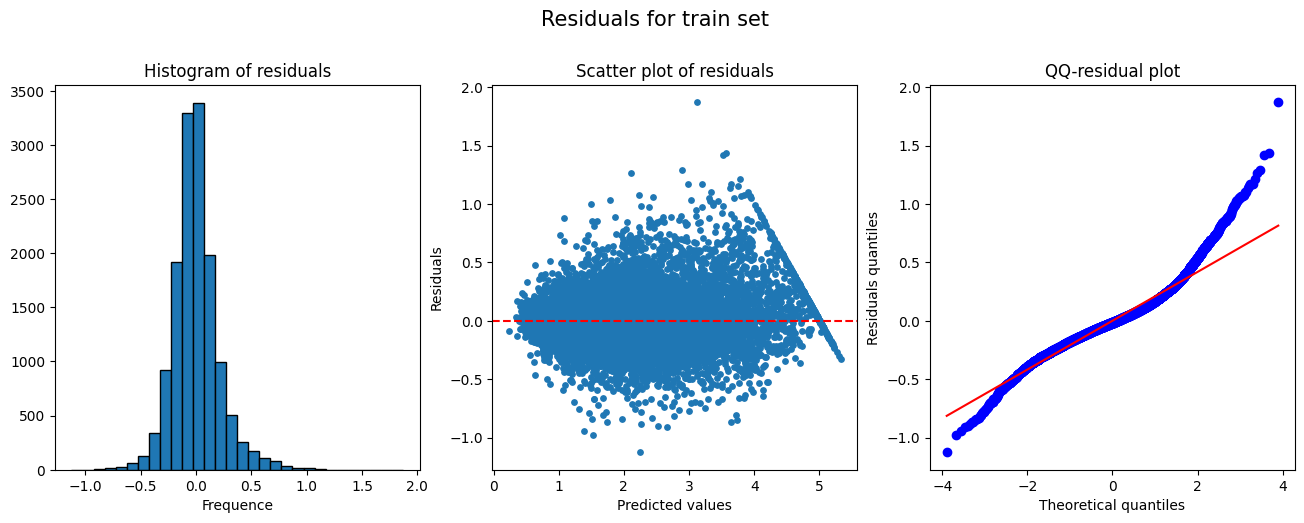

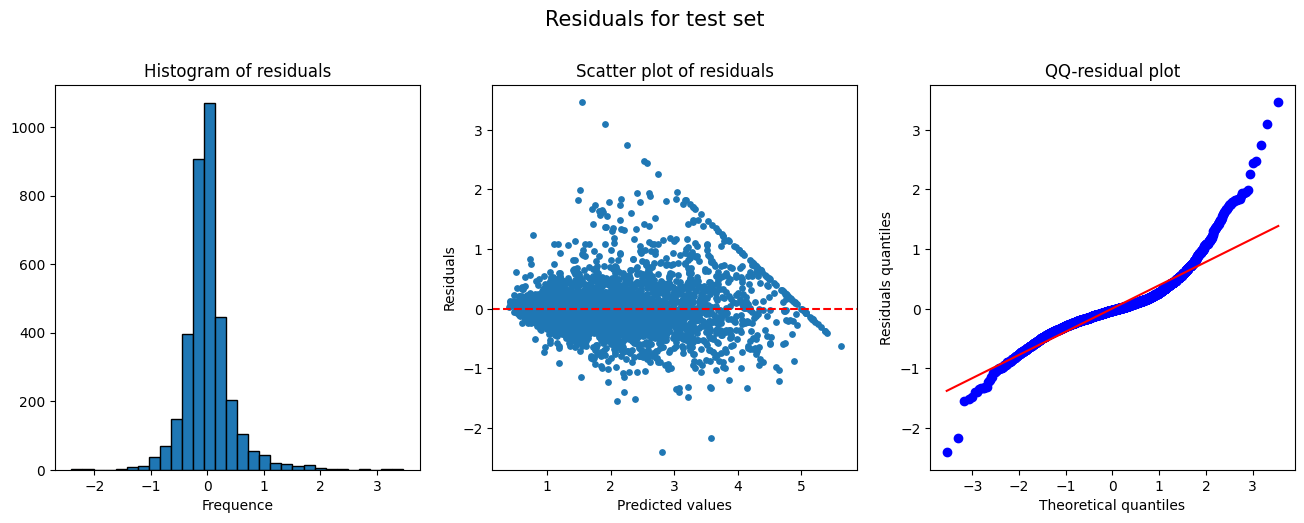

In [12]:
plot_residuals(y_combined, pred_train, "Residuals for train set")
plot_residuals(y_test, pred_test, "Residuals for test set")

The $R^2$ scores of 0.959 and 0.853 for the train set and test set respectively, clearly show that this non-linear model has adapted better compared to linear model.   

- **Residual Distribution:** The residuals are approximately normally distributed around zero, indicating no major bias in predictions. However, slight asymmetry and outliers suggest some data points are not fully captured by the model.   

- **Heteroscedasticity:** The cone shape in the residuals vs. predicted values plot suggests heteroscedasticity, meaning the variance of errors increases with the predicted values. This may affect model robustness.   

- **Normality of Residuals:** The QQ plot shows deviations from normality, particularly in the tails, indicating that the model has more extreme errors than expected under normal assumptions.   

# Conclusion

| Model                              | MSE   | R²    | Adjusted R² |
|------------------------------------|-------|-------|-------------|
| **Regression Models**              |       |       |             |
| Simplest model                     | 0.531 | 0.596 | 0.595       |
| Model without outliers             | 0.393 | 0.646 | 0.646       |
| Model without outliers + removing 'AveBrms' | 0.406 | 0.635 | 0.635 |
| Model without outliers + new feature       | 0.399 | 0.641 | 0.641 |
| **CatBoost model**                 | 0.170 | **0.853** | **0.853**       |


The simplest regression model, with a mean squared error (MSE) of 0.531 and an $R^2$ of 0.596, provided the baseline performance. Removing outliers improved model accuracy, reducing the MSE to 0.393 and increasing the $R^2$ to 0.646. Further adjustments, such as removing `AveBedrms` and adding a new feature, led to slight variations but did not surpass the performance achieved after handling outliers.

The CatBoost model, however, significantly outperformed all regression models, achieving an MSE of 0.170 and an R² of 0.853. It was able to capture complex patterns in the data and offer substantial gains in predictive accuracy compared to traditional regression approaches.